# Reactiva Perú – Reprogramación de Créditos
## Unidad 1: Perfil del Proyecto y Dataset Preprocesado (CRISP-DM)

**Autores:** Lucero Balbin Luis Keny - Del Castillo Yunca Alexis Frank - Attilano Cango May Diamond

**Curso:** Minería de Datos

**Fecha:** 2025-09-08

---
Este cuaderno implementa la primera entrega del proyecto siguiendo **CRISP-DM**:
1) Comprensión del negocio.
2) Comprensión y preparación de los datos.
3) Planificación del modelado.
4) Entrega de dataset limpio y documentado.


## 1. Perfil del Proyecto

### 1.1 Título
Análisis y predicción de la reprogramación de créditos de Reactiva Perú mediante técnicas de minería de datos

### 1.2 Problema / Caso de negocio
El programa Reactiva Perú otorgó créditos con garantía estatal a empresas para sostener su capital de trabajo durante la pandemia. Una proporción relevante de empresas reprogramó sus créditos. Interesa identificar factores asociados a la reprogramación y preparar un dataset que permita, en fases posteriores, construir modelos predictivos.

### 1.3 Propósito / Valor esperado
- Detectar patrones asociados a la reprogramación de créditos.
- Entregar un dataset limpio y estructurado apto para modelado.
- Sentar bases para modelos de clasificación en fases siguientes.

### 1.4 Justificación
- Evaluar la eficacia del programa frente a la crisis.
- Reconocer sectores/regiones con mayor vulnerabilidad.
- Aplicar técnicas de minería de datos en un caso real con valor público.

### 1.5 Objetivos
**General:** Analizar y preparar datos de Reactiva Perú para explicar y predecir reprogramación de créditos.

**Específicos:**

1. Describir el contexto y variables del dataset.

2. Aplicar limpieza, transformación y documentación del dataset (ETL/ELT).

3. Planificar técnicas de modelado (clasificación) y métricas de evaluación.


### 1.6 Alcance
Se trabaja con datos públicos del MEF sobre reprogramación de créditos. No se usa información financiera privada ni se realiza análisis macroeconómico completo.


## 2. Metodología: CRISP-DM

1) **Comprensión del negocio:** definición del problema y objetivos.
2) **Comprensión de los datos:** inventario de variables, calidad de datos, distribución.
3) **Preparación de datos:** limpieza, transformación, codificación, reducción.
4) **Modelado (planificación):** propuesta de algoritmos y métricas.
5) **Evaluación (planificación):** criterios: precisión, recall, F1.
6) **Despliegue (futuro):** uso para decisiones públicas/financieras.


## 3. Configuración e importaciones

In [1]:

import os
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)

print('Versiones -> pandas:', pd.__version__, '| numpy:', np.__version__)


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Versiones -> pandas: 2.2.2 | numpy: 1.26.4


## 4. Ruta de datos y carga

In [2]:

# Ajusta la ruta y el nombre de archivo si corresponde.
# Se soporta un único Excel o una lista de archivos para concatenación.

RUTA_DATOS = './'  # cambia si el archivo está en otra carpeta
ARCHIVOS_EXCEL = [
    'reactiva_peru_2022.xlsx'  # ejemplo: reemplaza por el nombre real si es distinto
]

# Lectura y concatenación
frames = []
for f in ARCHIVOS_EXCEL:
    path = os.path.join(RUTA_DATOS, f)
    if not os.path.exists(path):
        print('Advertencia: no se encontró', path)
    else:
        frames.append(pd.read_excel(path))

if frames:
    df_raw = pd.concat(frames, ignore_index=True)
else:
    # fallback: crear un df vacío para no romper el cuaderno
    df_raw = pd.DataFrame()

print('Forma del dataset original:', df_raw.shape)
df_raw.head(3)

# Definir dataset base para análisis descriptivo
if 'df' in globals():
    df_base = df.copy()
elif 'df_raw' in globals():
    df_base = df_raw.copy()
else:
    raise ValueError("No se encontró df ni df_raw. Ejecuta primero la parte 4 (carga de datos).")

Forma del dataset original: (446784, 9)


## 5. Comprensión de los Datos – Diccionario inicial

Documentar variables clave. Completar el CSV `diccionario_variables.csv` generado al final de este cuaderno.

Variables típicas en Reactiva Perú (ajustar según columnas reales):

- ORDEN: índice interno del registro.

- RAZÓN SOCIAL: nombre de la empresa (identificador, no se usa para modelado).

- RUC/DNI: identificador numérico de la empresa (no para modelado).

- SECTOR ECONÓMICO: rubro de la empresa.

- DEPARTAMENTO: ubicación geográfica.

- ENTIDAD FINANCIERA: banco o financiera otorgante.

- SALDO INSOLUTO: monto pendiente de pago.

- COBERTURA SALDO INSOLUTO: monto garantizado por el Estado.

- REPROGRAMACIÓN: indicador de si el crédito fue reprogramado (Sí/No).



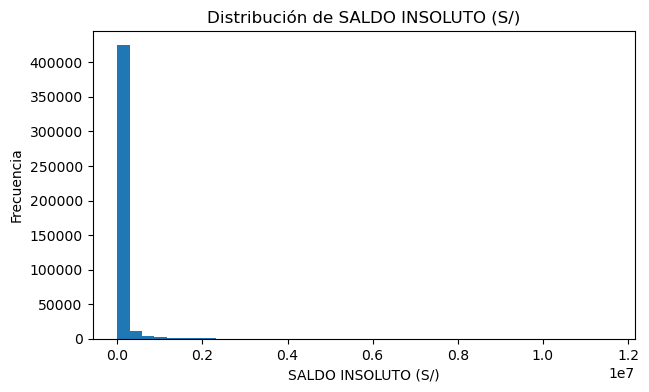

/tmp/ipykernel_33/1131134852.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


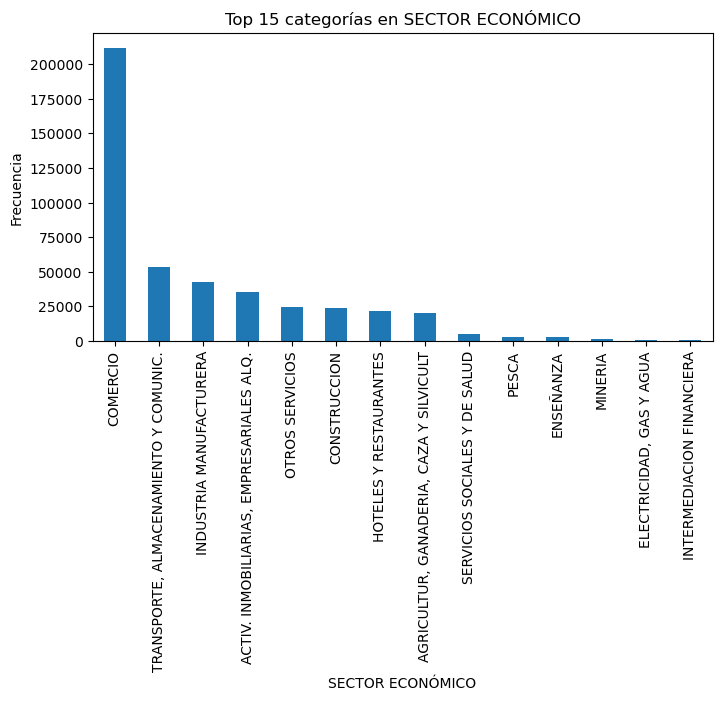

In [3]:
# 7. EDA básica

# Distribución de una variable numérica clave
col_monto = None
for c in df_raw.columns:
    if 'SALDO' in c.upper() or 'MONTO' in c.upper():
        col_monto = c
        break

if col_monto is not None:
    plt.figure(figsize=(7,4))
    df_raw[col_monto].dropna().astype(float).plot(kind='hist', bins=40)
    plt.title(f'Distribución de {col_monto}')
    plt.xlabel(col_monto)
    plt.ylabel('Frecuencia')
    plt.show()
else:
    print('No se encontró columna de monto o saldo para histograma.')

# Conteo por sector económico (o variable categórica relevante)
cat_col = None
candidates = ['SECTOR', 'SECTOR ECONÓMICO', 'SECTOR_ECONOMICO']
upper_cols = {c.upper(): c for c in df_raw.columns}
for cand in candidates:
    if cand in upper_cols:
        cat_col = upper_cols[cand]
        break

if cat_col is not None:
    conteo = df_raw[cat_col].astype(str).value_counts().head(15)
    plt.figure(figsize=(8,4))
    conteo.plot(kind='bar')
    plt.title(f'Top 15 categorías en {cat_col}')
    plt.xlabel(cat_col)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()
else:
    print('No se encontró columna de sector económico para gráfico de barras.')


In [4]:
# 8. Preparación de datos: limpieza

df = df_raw.copy()

# Estandarización de nombres de columnas
df.columns = [str(c).strip().replace('\n',' ').replace('  ',' ') for c in df.columns]

# Eliminación de duplicados exactos
df = df.drop_duplicates().reset_index(drop=True)

# Conversión de posibles montos a numérico (intenta detectar columnas con 'SALDO' o 'MONTO')
for c in df.columns:
    if any(k in c.upper() for k in ['SALDO', 'MONTO']):
        # Quitar comas, espacios y símbolos si existen, luego convertir
        df[c] = (
            df[c]
            .astype(str)
            .str.replace('[^0-9\.-]', '', regex=True)
            .replace({'': np.nan, '-': np.nan})
        )
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Tratamiento de nulos básicos: ejemplo simple (ajustar a criterio)
# Regla: si una columna numérica tiene pocos nulos, rellenar con mediana; si muchos nulos, evaluar descartar
threshold = 0.3  # 30% tolerancia
for c in df.columns:
    null_rate = df[c].isna().mean()
    if df[c].dtype.kind in 'biufc':  # numérica
        if null_rate > 0 and null_rate <= threshold:
            df[c] = df[c].fillna(df[c].median())
    else:
        # Categóricas: rellenar nulos con 'DESCONOCIDO' si es bajo el umbral
        if null_rate > 0 and null_rate <= threshold:
            df[c] = df[c].fillna('DESCONOCIDO')

# Eliminación de columnas con demasiados nulos
cols_to_drop = [c for c in df.columns if df[c].isna().mean() > 0.6]
df = df.drop(columns=cols_to_drop)

print('Columnas eliminadas por nulos > 60%:', cols_to_drop)
print('Forma tras limpieza:', df.shape)
df.head(3)


<>:18: SyntaxWarning: invalid escape sequence '\.'
<>:18: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_33/821230159.py:18: SyntaxWarning: invalid escape sequence '\.'
  .str.replace('[^0-9\.-]', '', regex=True)


Columnas eliminadas por nulos > 60%: []
Forma tras limpieza: (446784, 9)


,ORDEN,RAZÓN SOCIAL,RUC/DNI,SECTOR ECONÓMICO,NOMBRE DE ENTIDAD OTORGANTE DEL CRÉDITO,DEPARTAMENTO,SALDO INSOLUTO (S/),COBERTURA DEL SALDO INSOLUTO(S/),REPRO
0,1,_x001A_USTA SAGRADA SAC,20553879150,HOTELES Y RESTAURANTES,BANCO BBVA PERU,LIMA,188862.88,179419.7360,NO
1,2,2L SOLUCIONES S.A.C.,20524693250,"ACTIV. INMOBILIARIAS, EMPRESARIALES ALQ.",CRÉDITO,LIMA,124896.00,118651.2000,SI
2,3,3P INVERSIONES S.A.C.,20551286348,COMERCIO,CRÉDITO,LIMA,75295.93,71531.1335,NO


In [5]:
# 9. Preparación de datos: selección y codificación

# Identificadores a descartar del modelado
id_like = []
for c in df.columns:
    cu = c.upper()
    if any(k in cu for k in ['RUC', 'DNI', 'RAZON', 'RAZÓN', 'ORDEN', 'NOMBRE']):
        id_like.append(c)

df_model = df.drop(columns=id_like, errors='ignore')

# Variable objetivo: REPROGRAMACIÓN
y_col = None
for c in df.columns:
    if 'REPRO' in c.upper():
        y_col = c
        break

if y_col is not None:
    # Convertir a binaria 1/0 si es texto
    if df_model[y_col].dtype == object:
        df_model[y_col] = df_model[y_col].str.strip().str.upper().map({'SI':1, 'SÍ':1, 'YES':1, 'Y':1, '1':1, 'NO':0, 'N':0, '0':0})
    # Asegurar tipo numérico
    df_model[y_col] = pd.to_numeric(df_model[y_col], errors='coerce')

# One-Hot Encoding para categóricas
cat_cols = df_model.select_dtypes(include=['object']).columns.tolist()
df_model = pd.get_dummies(df_model, columns=cat_cols, dummy_na=False)

print('Forma dataset de modelado (temporal):', df_model.shape)
df_model.head(3)


Forma dataset de modelado (temporal): (446784, 42)


,SALDO INSOLUTO (S/),COBERTURA DEL SALDO INSOLUTO(S/),REPRO,"SECTOR ECONÓMICO_ACTIV. INMOBILIARIAS, EMPRESARIALES ALQ.","SECTOR ECONÓMICO_AGRICULTUR, GANADERIA, CAZA Y SILVICULT",SECTOR ECONÓMICO_COMERCIO,SECTOR ECONÓMICO_CONSTRUCCION,"SECTOR ECONÓMICO_ELECTRICIDAD, GAS Y AGUA",SECTOR ECONÓMICO_ENSEÑANZA,SECTOR ECONÓMICO_HOTELES Y RESTAURANTES,SECTOR ECONÓMICO_INDUSTRIA MANUFACTURERA,SECTOR ECONÓMICO_INTERMEDIACION FINANCIERA,SECTOR ECONÓMICO_MINERIA,SECTOR ECONÓMICO_OTROS SERVICIOS,SECTOR ECONÓMICO_PESCA,SECTOR ECONÓMICO_SERVICIOS SOCIALES Y DE SALUD,"SECTOR ECONÓMICO_TRANSPORTE, ALMACENAMIENTO Y COMUNIC.",DEPARTAMENTO_AMAZONAS,DEPARTAMENTO_ANCASH,DEPARTAMENTO_APURIMAC,DEPARTAMENTO_AREQUIPA,DEPARTAMENTO_AYACUCHO,DEPARTAMENTO_CAJAMARCA,DEPARTAMENTO_CALLAO,DEPARTAMENTO_CUSCO,DEPARTAMENTO_HUANCAVELICA,DEPARTAMENTO_HUANUCO,DEPARTAMENTO_ICA,DEPARTAMENTO_JUNIN,DEPARTAMENTO_LA LIBERTAD,DEPARTAMENTO_LAMBAYEQUE,DEPARTAMENTO_LIMA,DEPARTAMENTO_LORETO,DEPARTAMENTO_MADRE DE DIOS,DEPARTAMENTO_MOQUEGUA,DEPARTAMENTO_PASCO,DEPARTAMENTO_PIURA,DEPARTAMENTO_PUNO,DEPARTAMENTO_SAN MARTIN,DEPARTAMENTO_TACNA,DEPARTAMENTO_TUMBES,DEPARTAMENTO_UCAYALI
0,188862.88,179419.7360,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,124896.00,118651.2000,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,75295.93,71531.1335,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [6]:
# 10. Normalización opcional de variables numéricas

from sklearn.preprocessing import MinMaxScaler

if 'y_col' in locals() and y_col in df_model.columns:
    features = [c for c in df_model.columns if c != y_col]
else:
    features = df_model.columns.tolist()

scaler = MinMaxScaler()
df_scaled = df_model.copy()
df_scaled[features] = scaler.fit_transform(df_model[features])

print('Forma del dataset escalado:', df_scaled.shape)
df_scaled.head(3)


Forma del dataset escalado: (446784, 42)


,SALDO INSOLUTO (S/),COBERTURA DEL SALDO INSOLUTO(S/),REPRO,"SECTOR ECONÓMICO_ACTIV. INMOBILIARIAS, EMPRESARIALES ALQ.","SECTOR ECONÓMICO_AGRICULTUR, GANADERIA, CAZA Y SILVICULT",SECTOR ECONÓMICO_COMERCIO,SECTOR ECONÓMICO_CONSTRUCCION,"SECTOR ECONÓMICO_ELECTRICIDAD, GAS Y AGUA",SECTOR ECONÓMICO_ENSEÑANZA,SECTOR ECONÓMICO_HOTELES Y RESTAURANTES,SECTOR ECONÓMICO_INDUSTRIA MANUFACTURERA,SECTOR ECONÓMICO_INTERMEDIACION FINANCIERA,SECTOR ECONÓMICO_MINERIA,SECTOR ECONÓMICO_OTROS SERVICIOS,SECTOR ECONÓMICO_PESCA,SECTOR ECONÓMICO_SERVICIOS SOCIALES Y DE SALUD,"SECTOR ECONÓMICO_TRANSPORTE, ALMACENAMIENTO Y COMUNIC.",DEPARTAMENTO_AMAZONAS,DEPARTAMENTO_ANCASH,DEPARTAMENTO_APURIMAC,DEPARTAMENTO_AREQUIPA,DEPARTAMENTO_AYACUCHO,DEPARTAMENTO_CAJAMARCA,DEPARTAMENTO_CALLAO,DEPARTAMENTO_CUSCO,DEPARTAMENTO_HUANCAVELICA,DEPARTAMENTO_HUANUCO,DEPARTAMENTO_ICA,DEPARTAMENTO_JUNIN,DEPARTAMENTO_LA LIBERTAD,DEPARTAMENTO_LAMBAYEQUE,DEPARTAMENTO_LIMA,DEPARTAMENTO_LORETO,DEPARTAMENTO_MADRE DE DIOS,DEPARTAMENTO_MOQUEGUA,DEPARTAMENTO_PASCO,DEPARTAMENTO_PIURA,DEPARTAMENTO_PUNO,DEPARTAMENTO_SAN MARTIN,DEPARTAMENTO_TACNA,DEPARTAMENTO_TUMBES,DEPARTAMENTO_UCAYALI
0,0.016306,0.019363,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.010783,0.012805,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.006501,0.007720,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# 11. Guardado de artefactos
#  - Dataset limpio (df)
#  - Dataset modelado (df_model)
#  - Dataset escalado (df_scaled)
#  - Diccionario de variables (plantilla)

OUTPUT_DIR = './salidas_unidad1'
os.makedirs(OUTPUT_DIR, exist_ok=True)

path_clean = os.path.join(OUTPUT_DIR, 'reactiva_clean.csv')
path_model = os.path.join(OUTPUT_DIR, 'reactiva_model.csv')
path_scaled = os.path.join(OUTPUT_DIR, 'reactiva_scaled.csv')

df.to_csv(path_clean, index=False, encoding='utf-8')
df_model.to_csv(path_model, index=False, encoding='utf-8')
df_scaled.to_csv(path_scaled, index=False, encoding='utf-8')

print('Guardado:')
print(' -', path_clean)
print(' -', path_model)
print(' -', path_scaled)


Guardado:
 - ./salidas_unidad1/reactiva_clean.csv
 - ./salidas_unidad1/reactiva_model.csv
 - ./salidas_unidad1/reactiva_scaled.csv


In [16]:
# 12. Plantilla de diccionario de variables y tratamientos
cols = list(df_raw.columns)
template = pd.DataFrame({
    'variable_original': cols,
    'descripcion': [''] * len(cols),
    'tipo_dato': ['numerica/categorica/fecha'] * len(cols),
    'tratamientos_aplicados': ['limpieza/codificacion/normalizacion/otra'] * len(cols),
    'observaciones': [''] * len(cols)
})
DICT_PATH = os.path.join(OUTPUT_DIR, 'diccionario_variables.csv')
template.to_csv(DICT_PATH, index=False, encoding='utf-8')
print('Plantilla creada:', DICT_PATH)
template.head(10)


Plantilla creada: ./salidas_unidad1/diccionario_variables.csv


,variable_original,descripcion,tipo_dato,tratamientos_aplicados,observaciones
0,ORDEN,,numerica/categorica/fecha,limpieza/codificacion/normalizacion/otra,
1,RAZÓN SOCIAL,,numerica/categorica/fecha,limpieza/codificacion/normalizacion/otra,
2,RUC/DNI,,numerica/categorica/fecha,limpieza/codificacion/normalizacion/otra,
3,SECTOR ECONÓMICO,,numerica/categorica/fecha,limpieza/codificacion/normalizacion/otra,
4,NOMBRE DE ENTIDAD OTORGANTE DEL CRÉDITO,,numerica/categorica/fecha,limpieza/codificacion/normalizacion/otra,
5,DEPARTAMENTO,,numerica/categorica/fecha,limpieza/codificacion/normalizacion/otra,
6,SALDO INSOLUTO (S/),,numerica/categorica/fecha,limpieza/codificacion/normalizacion/otra,
7,COBERTURA DEL SALDO INSOLUTO(S/),,numerica/categorica/fecha,limpieza/codificacion/normalizacion/otra,
8,REPRO,,numerica/categorica/fecha,limpieza/codificacion/normalizacion/otra,


## 13. Planificación para el Modelado

Problema de clasificación binaria: predecir la reprogramación del crédito.
Modelos candidatos: Regresión Logística, Árboles de Decisión, Random Forest.
Métricas: precisión, recall, F1-score. Validación con train/test split o validación cruzada.


In [17]:
# 13.1 División de datos
from sklearn.model_selection import train_test_split

if 'y_col' in locals() and y_col in df_scaled.columns:
    X = df_scaled.drop(columns=[y_col])
    y = df_scaled[y_col].fillna(0).astype(int)  # fallback simple
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
else:
    print('No se detectó variable objetivo de reprogramación. Define la columna que indica REPRO.')


(357427, 41) (89357, 41) (357427,) (89357,)


## 14. Conclusiones iniciales

1) Se documentó el contexto y los objetivos del proyecto.
2) Se auditó la calidad de datos y se aplicaron reglas básicas de limpieza.
3) Se generó un dataset limpio y versiones transformadas aptas para modelado.
4) Se dejó preparado el pipeline para partición de datos y futura etapa de modelado.
